# Tutorial 1: Getting started with Rabbit

In this tutorial you will learn the most basic features, useful scripts, and commands to work with rabbit.

## Setting up the environment

There are many ways to set a working environment. The following is a suggestion that works on my local laptop.

In your terminal, clone the rabbit repository:
``` bash
git clone git@github.com:WMass/rabbit.git
cd rabbit
```

Create a virtual environment (requires python 3.12 or higher):
``` bash
python -m venv env
source env/bin/activate
pip install wums[pickling,plotting] tensorflow tensorflow-probability numpy h5py hist scipy matplotlib mplhep seaborn pandas plotly kaleido
```

Install jupyter notebook specific packages and the kernel spec:
``` bash
pip install ipykernel
python -m ipykernel install --user --name=rabbit_env --display-name "Python (Rabbit)"
```

Start jupyter notebook:
``` bash
jupyter notebook
```

After starting jupyter notebook, open the browser link, and navigate to this file you have to activate the kernel with the environment. Go to "Kernel" -> "Change kernel" -> "Python (Rabbit)".
If everything done right the following command should print the python path inside your python virtual environment:

In [1]:
import sys
print(sys.executable)

/home/david/work/Repos/rabbit/env/bin/python


Since we are using a lot of bash scripts we need to set the environment variables. Outside of a notebook this is done by running `source setup.sh` from the repository root. The cell below replicates the same effect inside the notebook:

In [2]:
import os
import sys
from pathlib import Path

# 1. Emulate RABBIT_BASE (points to the 'rabbit' root)
# Since we are in rabbit/notebooks/, we go up one level
rabbit_base = str(Path(os.getcwd()).parent.absolute())
os.environ['RABBIT_BASE'] = rabbit_base

# 2. Update PYTHONPATH so you can 'import rabbit'
if rabbit_base not in sys.path:
    sys.path.append(rabbit_base)
# 2.1 PYTHONPATH also needs to be set to run bash scripts starting with "!"
pythonpath = os.environ.get('PYTHONPATH', '')
if rabbit_base not in pythonpath:
    os.environ['PYTHONPATH'] = rabbit_base + os.pathsep + pythonpath if pythonpath else rabbit_base
    
# 3. Update PATH so you can run scripts from rabbit/bin/
bin_path = os.path.join(rabbit_base, 'bin')
if bin_path not in os.environ['PATH']:
    os.environ['PATH'] = bin_path + os.pathsep + os.environ['PATH']
    
print(f"RABBIT_BASE: {os.environ['RABBIT_BASE']}")
print(f"PATH: {os.environ['PATH']}")

RABBIT_BASE: /home/david/work/Repos/rabbit
PATH: /home/david/work/Repos/rabbit/bin:/home/david/work/Repos/rabbit/env/bin:/home/david/.local/bin:/home/david/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin


The following is needed to visualize the plots within this session

In [3]:
from IPython.display import Image, display, IFrame, HTML

## Generating a synthetic toy model

Let's start creating some toy data, a 1D histogram with 10 bins with a Gaussian signal, a flat background, and an exponentially falling background:

In [ ]:
import numpy as np
import hist

axis = hist.axis.Regular(10,0,1, name="x")

# Create histograms for signal, 2 backgrounds, and data 
h_sig = hist.Hist(axis, storage=hist.storage.Weight())  
h_flat = hist.Hist(axis, storage=hist.storage.Weight())  
h_exp = hist.Hist(axis, storage=hist.storage.Weight())  
h_data = hist.Hist(axis, storage=hist.storage.Double())  
  
# Generate and fill components with weights  
np.random.seed(42)  
# Gaussian signal (mean=0.5, std=0.1) with weights  
sig_samples = np.random.normal(0.5, 0.1, 5000)
sig_weights = np.random.normal(1.0, 0.2, 5000)  # Mean weight=1, sigma=0.2 
h_sig.fill(sig_samples, weight=sig_weights)  
  
# Flat background with weights  
flat_samples = np.random.uniform(0, 1, 4000)  
flat_weights = np.random.normal(0.5, 0.1, 4000)  # Mean weight=0.5, sigma=0.1
h_flat.fill(flat_samples, weight=flat_weights)  
  
# Exponential background with weights  
exp_samples = np.random.exponential(0.2, 2000)  
exp_weights = np.random.normal(1.5, 0.3, 2000)  # Mean weight=1.5, sigma=0.3
h_exp.fill(exp_samples, weight=exp_weights)  
  
# Sum components and add Poisson fluctuations
h_data.values()[...] = np.random.poisson(  
    h_sig.values() + h_flat.values() + h_exp.values()  
)

You can visualize any of the histograms e.g.:

In [5]:
print(h_data)

                 ┌───────────────────────────────────────────────────────────┐
[-inf,   0) 0    │                                                           │
[   0, 0.1) 1325 │█████████████████████████████████████                      │
[ 0.1, 0.2) 927  │█████████████████████████▉                                 │
[ 0.2, 0.3) 773  │█████████████████████▋                                     │
[ 0.3, 0.4) 1152 │████████████████████████████████▏                          │
[ 0.4, 0.5) 2078 │██████████████████████████████████████████████████████████ │
[ 0.5, 0.6) 1969 │███████████████████████████████████████████████████████    │
[ 0.6, 0.7) 901  │█████████████████████████▏                                 │
[ 0.7, 0.8) 318  │████████▉                                                  │
[ 0.8, 0.9) 250  │███████                                                    │
[ 0.9,   1) 211  │█████▉                                                     │
[   1, inf) 0    │                                  

## Constructing the input file rabbit expects

To perform a binned profile maximum likelihood fit of the provided templates to the data histogram we need to construct an input file in the required format. Rabbit offers a python interface to do that. Multiple channels can be provided where each channel has an arbitrary number of axes. Histograms for the data and predictions, called processes, need to be provided in the same axes. In the underlying data structure the multi-dimensional histogram for each channel get unrolled and that flat arrays get concatenated.

In our case we just have one channel and histograms with a single axis. 

In [6]:
from rabbit import tensorwriter  
  
# Initialize TensorWriter  
writer = tensorwriter.TensorWriter(
    systematic_type="log_normal"
)  
  
# Add a channel 
#  each channel can have different axes and can for example represent an analysis region 
#  such as single lepton channel and dilepton channel
writer.add_channel([axis], name="ch0")
  
# Add observed data  
writer.add_data(h_data, "ch0")  
  
# Add processes: signal and backgrounds  
writer.add_process(h_sig, "signal", "ch0", signal=True)  
writer.add_process(h_flat, "flat_bkg", "ch0", signal=False)  
writer.add_process(h_exp, "exp_bkg", "ch0", signal=False)  

A real measurement has systematic uncertainties. Rabbit does not distinguish between normalization and shape uncertainties. Each uncertainty source is characterized by one up and one down variation across all bins, per process. Internally a 4D tensor is constructed with (processes, bins, systematics, up/down) variation. It is possible to symmetrize systematic variations to make the likelihood more quadratic and aid the minimization and establish validity of Gaussian approximations for example for the uncertainty estimation. 
* For systematic variations that are expected to by symmetric (but may have some statistical fluctuations which makes them asymmetric) the option "average" is recommended which is, as the name suggests, building the average of the up and down variation. 
* For ones that are known to be asymmetric, the "linear" or "quadratic" (more conservative) options are recommended where the asymmetric variation is split into two symmetric variations, one for the average and one for the difference.
* If only one histogram is provided it will be assumed as symmetric and mirrored.

If systematic uncertainties are only provided for a subset of the channels or processes the variations get zero padded. 

By default, all systematic uncertainties have a multiplicative effect on the predicted yield and are log-normal constraint. Alternatively additive normal constrained systematics can be used by setting systematic_type to "normal" in the TensorWriter construction.

In [7]:
# Normalization systematics
writer.add_norm_systematic("lumi", ["signal", "flat_bkg", "exp_bkg"], "ch0", 1.01)
writer.add_norm_systematic("flat_bkg_norm", "flat_bkg", "ch0", 1.05)
writer.add_norm_systematic("exp_bkg_norm", "exp_bkg", "ch0", 1.07)

# Shape systematics: create up/down variations  
def make_shape_var(h, factor_func):  
    h_var = h.copy()  
    centers = h.axes[0].centers  
    weights = factor_func(centers)  
    h_var.values()[...] = h.values() * (1 + weights)  
    return h_var  
  
# Example: asymmetric shape systematic for flat systematic  
h_flat_up = make_shape_var(h_flat, lambda c: 0.05 * np.exp(2 * (c - 0.5)))  
h_flat_dn = make_shape_var(h_flat, lambda c: -0.03 * np.exp(2 * (c - 0.5))) 
writer.add_systematic(  
    [h_flat_up, h_flat_dn],  
    "flat_bkg_shape",  
    "flat_bkg",  
    "ch0",  
    symmetrize="linear", # this splits the systematic into two: 'flat_bkg_shapeSymAvg' and 'flat_bkg_shapeSymDiff'
    constrained=True,  
) 
  
# Example: linear slope systematic for signal  
h_sig_up = make_shape_var(h_sig, lambda c: 0.5 * (c - 0.5))  
h_sig_dn = make_shape_var(h_sig, lambda c: -0.5 * (c - 0.5))  
writer.add_systematic(  
    [h_sig_up, h_sig_dn],  
    "slope",  
    "signal",  
    "ch0",  
    symmetrize="average",  
    constrained=False,  
)

/home/david/work/Repos/rabbit/rabbit/tensorwriter.py:459: RuntimeWarning: invalid value encountered in divide
  _logk = kfac * np.log(syst / norm)


Finally, we store the file on disk. Note that a `RuntimeWarning: invalid value encountered in divide` may appear when adding systematics — this is expected and harmless. It occurs when a process has zero nominal yield in some bins, causing `log(0)` during the internal log-normal encoding; those entries are clipped to a small numerical value automatically.

In [9]:
import os

directory="results/getting_started/"
if not os.path.exists(directory):
    os.makedirs(directory)

# Write the input tensor to HDF5  
writer.write(
    outfilename=f"{directory}/input.hdf5"
)

The following steps are using bash commands to investigate

## Input data diagnostics

First, let us look if the input data looks healthy

In [10]:
!debug_inputdata.py results/getting_started/input.hdf5 -v 4

2026-02-27 20:02:50.498638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 20:02:50.499025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 20:02:50.555823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 20:02:51.916086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Looks good! However, the scripts does not know what you are trying to do and the checks have a limited coverage. It does not guarantee that things work. 
More insight can be obtained from looking at the data, nominal predictions, and systematic variations, exactly as they go into the fit. Do the variations look sane to you?

2026-02-27 20:06:26.836494: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 20:06:26.836876: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 20:06:26.890034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 20:06:28.214774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

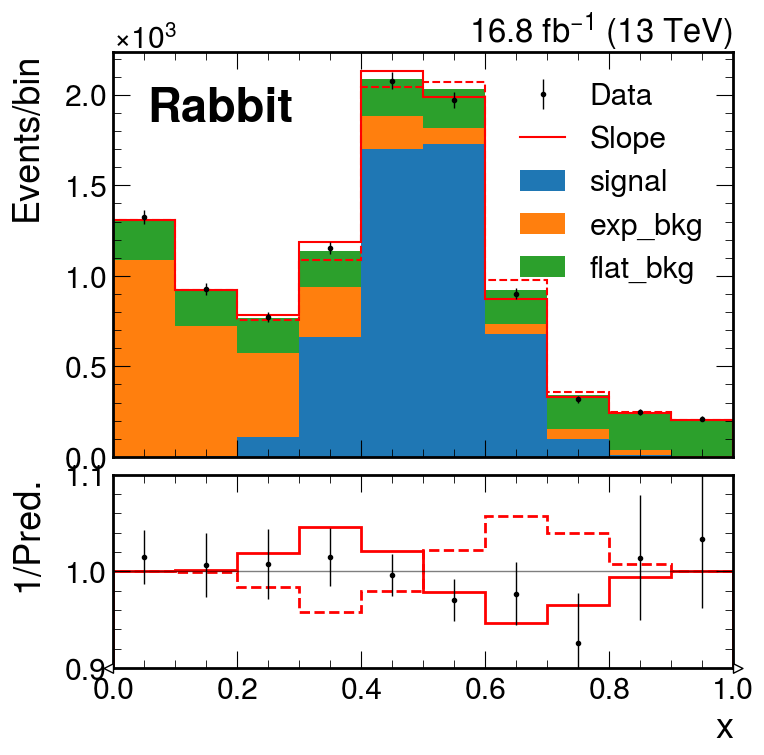

In [12]:
!rabbit_plot_inputdata.py ./results/getting_started/input.hdf5 -o ./results/getting_started --legCols 1 \
--varName slope --varLabel 'Slope' --varColor red

display(Image(filename='results/getting_started/hist_stack_x_ch0.png'))

## Fit

From the provided input data a likelihood function is constructed that has to be maximized. As usual, the negative logarithm of the likelihood is implemented for minimization and constant terms are neglected:

$-\ln\left( \mathcal{L} \right) = \sum_{i=1}^\mathrm{bins} \left[ n^\mathrm{exp}_i - n^\mathrm{obs}_i \ln(n^\mathrm{exp}_i) \right] + \frac{1}{2} \sum_{k=1}^\mathrm{syst} \left(\theta_k - \theta^0_k\right)^2 + \sum_{i=1}^\mathrm{bins} \left[ k^\mathrm{stat}_i \beta_i - k^\mathrm{stat}_i \beta_i^0 \ln(\beta_i) \right]$

with $n_i = \sum_j^\mathrm{proc} f_{i,j}(\vec{\mu}) \beta_i n_{i,j}^0 \prod_k^\mathrm{syst} \kappa_{i,j,k}^{\theta_k}$ and $\kappa_{i, j, k} = \frac{n^0_{i,j} + v_{i, j, k}}{n^0_{i,j}}$. 
With the bin index $i$, process index $j$ and systematic index $k$. The parameters associated to each systematic variation is $\theta$ while $\theta^0$ is the constraint minimum that is by default set to 0 but can be varied for toy experiments. The $\beta$ and $\beta^0$ parameters account for the statistical uncertainty on the prediction and the Barlow--Beeston light approach is followed by default. The $k^\mathrm{stat}$ numbers encodes the statistical uncertainty on the predictions. The $\mu$ are parameters of interest (POI) and their effect on the yields is modelled via the so-called POI model $f$, which by default returns 1 for signal and 0 for background processes. 

The `-t` option selects which dataset to fit:
- `-t -1`: fit to the **Asimov dataset**, where observed data = sum of all prefit predictions. Use this to get expected sensitivities and to validate the fit setup before looking at real data.
- `-t 0`: fit to the **observed data**.
- Multiple values (e.g. `-t 0 -1`) run both fits and store the results under separate keys in the output file.

By default fits to data are **blinded**: a random offset is applied to the POIs so the true data result is not visible until you add `--unblind`.

To start with, we perform a fit to the Asimov dataset using `-t -1` and save:
- the expected prefit and postfit distribution (--saveHists) for each process (--saveHistsPerProcess) and the total uncertainties (--computeHistErrors)
- the effect of the systematic variations (--computeVariations)
- the uncertainty breakdown on the signal strength modifier following the traditional (--doImpacts) and global impacts definition (--globalImpacts)

When the fit terminates it prints out the estimated distance to the minimum (edmval). If the edmval is large (e.g. larger than 10^{-9}) it is a sign that the fit has not converged. 
It also prints the p-value from the saturated likelihood test in the asymptotic limit. This tells you how well your model describes the data.

In [13]:
!rabbit_fit.py ./results/getting_started/input.hdf5 -t -1 -o ./results/getting_started \
--saveHists --saveHistsPerProcess --computeHistErrors --computeVariations --doImpacts --globalImpacts

2026-02-27 20:09:32.214496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 20:09:32.214868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 20:09:32.267018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 20:09:33.680090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Fit Diagnostics

### Prefit & postfit plots

In [14]:
!rabbit_plot_hists.py results/getting_started/fitresults.hdf5 -m BaseMapping -o ./results/getting_started \
 --legCols 1 --rrange 0.8 1.2 --extraTextLoc 0.05 0.82 \
--varName slope --varLabel 'Slope' --varColor red --prefit

!rabbit_plot_hists.py results/getting_started/fitresults.hdf5 -m BaseMapping -o ./results/getting_started \
--legCols 1 --rrange 0.8 1.2 --extraTextLoc 0.05 0.82 \
--varName slope --varLabel 'Slope' --varColor red

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/getting_started/prefit_x_ch0_BaseMapping.png?v={v}" style="width: 45%;" />
    <img src="results/getting_started/postfit_x_ch0_BaseMapping.png?v={v}" style="width: 45%;" />
</div>
"""))

INFO:rabbit_plot_hists.py: Make plot for BaseMapping in channel ch0
INFO:plot_tools.py: Wrote file(s) ./results/getting_started//prefit_x_ch0_BaseMapping.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/getting_started//prefit_x_ch0_BaseMapping.pdf(.png)
INFO:rabbit_plot_hists.py: Make plot for BaseMapping in channel ch0
INFO:plot_tools.py: Wrote file(s) ./results/getting_started//postfit_x_ch0_BaseMapping.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/getting_started//postfit_x_ch0_BaseMapping.pdf(.png)


### Pulls and impacts

Impact parameter pulls and impacts are computed by default on all parameters of interest and in the Gaussian approximation. Here, the impact on the signal strength modifier is plotted.

In [15]:
!rabbit_plot_pulls_and_impacts.py results/getting_started/fitresults.hdf5 -o ./results/getting_started

IFrame(src='results/getting_started/pulls_and_impacts_signal.html', width='100%', height=300)

Now at signal
Write output file ./results/getting_started/pulls_and_impacts_signal.html
Write output file ./results/getting_started/impacts_grouped_signal.html


### Correlation matrix
Let's look at the correlation of some parameters

INFO:plot_tools.py: Wrote file(s) ./results/getting_started//hist_corr_postfit_parms_x_parms_y_params.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/getting_started//hist_corr_postfit_parms_x_parms_y_params.pdf(.png)


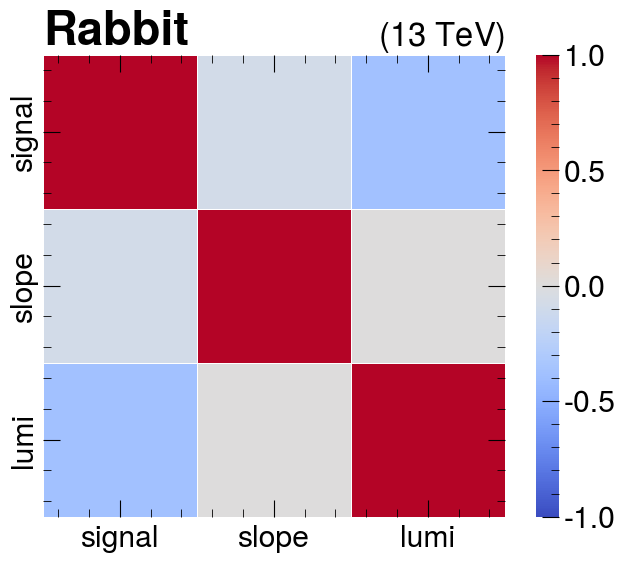

In [13]:
!rabbit_plot_hists_cov.py results/getting_started/fitresults.hdf5 \
--params signal slope lumi --correlation -o ./results/getting_started --titlePos 0

display(Image(filename='results/getting_started/hist_corr_postfit_parms_x_parms_y_params.png'))

### Likelihood scans

Let's perform another fit, this time on data and asimov (-t 0 -1). And also perform a likelihood scan of the signal strength modifier.

We also enable debug to see what is going on. 
The message "A bad approximation caused failure to predict improvement" is expected, what counts is the estimated distance to minimum (edmval), if this is low we are reassured to have found a good minimum.

In [14]:
!rabbit_fit.py results/getting_started/input.hdf5 -t 0 -1 -o ./results/getting_started \
--scan signal --postfix nll_scan -v 4

2026-02-27 14:32:46.333436: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 14:32:46.333706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 14:32:46.368039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 14:32:47.330733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

DEBUG:fitter.py: Iteration 103: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 104: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 105: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 106: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 107: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 108: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 109: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 110: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 111: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 112: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 113: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 114: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 115: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 116: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 117: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 118: loss value 0.4550678504

DEBUG:fitter.py: Iteration 227: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 228: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 229: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 230: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 231: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 232: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 233: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 234: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 235: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 236: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 237: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 238: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 239: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 240: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 241: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 242: loss value 0.4550678504

DEBUG:fitter.py: Iteration 345: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 346: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 347: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 348: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 349: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 350: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 351: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 352: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 353: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 354: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 355: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 356: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 357: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 358: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 359: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 360: loss value 0.4550678504

DEBUG:fitter.py: Iteration 468: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 469: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 470: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 471: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 472: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 473: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 474: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 475: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 476: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 477: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 478: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 479: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 480: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 481: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 482: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 483: loss value 0.4550678504

DEBUG:fitter.py: Iteration 582: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 583: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 584: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 585: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 586: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 587: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 588: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 589: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 590: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 591: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 592: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 593: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 594: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 595: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 596: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 597: loss value 0.4550678504

DEBUG:fitter.py: Iteration 701: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 702: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 703: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 704: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 705: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 706: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 707: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 708: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 709: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 710: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 711: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 712: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 713: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 714: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 715: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 716: loss value 0.4550678504

DEBUG:fitter.py: Iteration 822: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 823: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 824: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 825: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 826: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 827: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 828: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 829: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 830: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 831: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 832: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 833: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 834: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 835: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 836: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 837: loss value 0.4550678504

DEBUG:fitter.py: Iteration 940: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 941: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 942: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 943: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 944: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 945: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 946: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 947: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 948: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 949: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 950: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 951: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 952: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 953: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 954: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 955: loss value 0.4550678504

DEBUG:fitter.py: Iteration 1059: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1060: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1061: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1062: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1063: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1064: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1065: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1066: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1067: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1068: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1069: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1070: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1071: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1072: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1073: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1074: loss va

DEBUG:fitter.py: Iteration 1177: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1178: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1179: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1180: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1181: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1182: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1183: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1184: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1185: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1186: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1187: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1188: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1189: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1190: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1191: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1192: loss va

DEBUG:fitter.py: Iteration 1300: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1301: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1302: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1303: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1304: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1305: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1306: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1307: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1308: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1309: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1310: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1311: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1312: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1313: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1314: loss value 0.45506785046489384
DEBUG:fitter.py: Iteration 1315: loss va

/home/david/work/Repos/rabbit/env/lib/python3.12/site-packages/wums/ioutils.py:161: FutureWarning: .metadata was not set, returning None instead of Attribute error, boost-histogram 1.7+ will error.
  (axes, obj.storage_type(), obj.metadata, obj.label, obj.name, h5buf),
INFO:rabbit_fit.py: edmval: 7.600559610564e-30
INFO:rabbit_fit.py: Saturated chi2:
INFO:rabbit_fit.py:     ndof: 8
INFO:rabbit_fit.py:     2*deltaNLL: 0.0
INFO:rabbit_fit.py:     p-value: 100.0%
INFO:rabbit_fit.py: -delta log(L) scan for signal
Results written in file ./results/getting_started/fitresults_nll_scan.hdf5
INFO:rabbit_fit.py: 5.82 seconds total time
DEBUG:rabbit_fit.py: 1.67 seconds initialization time
DEBUG:rabbit_fit.py: For fit 0:
DEBUG:rabbit_fit.py: 0.01 seconds for prefit
DEBUG:rabbit_fit.py: 3.94 seconds for fit
DEBUG:rabbit_fit.py: 0.01 seconds for postfit
DEBUG:rabbit_fit.py: For fit -1:
DEBUG:rabbit_fit.py: 0.02 seconds for prefit
DEBUG:rabbit_fit.py: 0.16 seconds for fit
DEBUG:rabbit_fit.py: 0.00 s

In [15]:
!rabbit_plot_likelihood_scan.py results/getting_started/fitresults_nll_scan.hdf5 \
--param signal --postfix data -o ./results/getting_started/

!rabbit_plot_likelihood_scan.py results/getting_started/fitresults_nll_scan.hdf5 \
--param signal --postfix asimov --result asimov -o ./results/getting_started/

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/getting_started/nll_scan_signal_asimov.png?v={v}" style="width: 45%;" />
    <img src="results/getting_started/nll_scan_signal_data.png?v={v}" style="width: 45%;" />
</div>
"""))

Write output file ./results/getting_started/nll_scan_signal_data.png
Write output file ./results/getting_started/nll_scan_signal_data.pdf
Write output file ./results/getting_started/nll_scan_signal_asimov.png
Write output file ./results/getting_started/nll_scan_signal_asimov.pdf


Both scans agree very well from the Gaussian approximation from the Hesse matrix.
The "signal" value is shifted by a large amount in the fit to data, this is because by default a blinding offset is applied to parameters of interest. Let's remove it.

In [16]:
!rabbit_fit.py results/getting_started/input.hdf5 -t 0 -1 -o ./results/getting_started \
--scan signal --postfix nll_scan_unblinded -v 4 --unblind

2026-02-27 14:32:59.480374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 14:32:59.480618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 14:32:59.513401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 14:33:00.454683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [18]:
!rabbit_print_pulls_and_constraints.py results/getting_started/fitresults_nll_scan_unblinded.hdf5

   Parameter                        pull +/- constraint (pull prefit +/- constraint prefit)
   ----------------------------------------------------------------------------------------------------
   signal                         0.99043 +/-    0.01309 (        1.0 +/-               0.0)
   slope                          -0.51826 +/-    0.53436 (        0.0 +/-               0.0)
   exp_bkg_norm                   0.11113 +/-    0.49335 (        0.0 +/-               1.0)
   flat_bkg_norm                  0.00738 +/-     0.8977 (        0.0 +/-               1.0)
   flat_bkg_shapeSymAvg           0.09311 +/-     0.6746 (        0.0 +/-               1.0)
   flat_bkg_shapeSymDiff          0.01567 +/-    0.98815 (        0.0 +/-               1.0)
   lumi                             -0.0 +/-        1.0 (        0.0 +/-               1.0)


How to read the pulls table:
- **pull**: the postfit parameter value. For constrained nuisances this is in units of the prefit uncertainty (a pull of 0 means the nuisance is at its prefit central value, ±1 means it shifted by one standard deviation). For unconstrained parameters (POIs and free parameters like `slope`) it is the fitted value in its natural units.
- **constraint**: the postfit uncertainty, again in units of the prefit uncertainty for constrained nuisances. A value significantly less than 1 indicates the data is constraining that nuisance beyond the prior.
- The values in parentheses are the **prefit** equivalents: the prior central value and uncertainty before the fit.

In [19]:
!rabbit_plot_likelihood_scan.py results/getting_started/fitresults_nll_scan_unblinded.hdf5 \
--param signal --postfix data_unblinded -o ./results/getting_started

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/getting_started/nll_scan_signal_asimov.png?v={v}" style="width: 45%;" />
    <img src="results/getting_started/nll_scan_signal_data_unblinded.png?v={v}" style="width: 45%;" />
</div>
"""))

Write output file ./results/getting_started/nll_scan_signal_data_unblinded.png
Write output file ./results/getting_started/nll_scan_signal_data_unblinded.pdf


In [ ]:
## Summary

In this tutorial you have learned how to:
- Build an input tensor with `TensorWriter`: channels, processes, normalization and shape systematics
- Diagnose input data with `debug_inputdata.py` and `rabbit_plot_inputdata.py`
- Run a profile likelihood fit with `rabbit_fit.py` on Asimov (`-t -1`) and observed data (`-t 0`)
- Interpret fit results: prefit/postfit distributions, pulls and constraints, impacts, correlation matrix, and likelihood scans
- Use blinding and unblinding to protect the data result during fit development

**Next steps:** [Tutorial 2](tutorial_2_advanced.ipynb) covers multi-dimensional channels, masked channels for cross section measurements, custom mappings, and custom POI models.